In [1]:
#print('What\'s up!')

# Notebook imports

In [246]:
# To extract file names & directories
from os import walk
from os.path import join

# Data processing and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Splitting data into train and test sub datasets
from sklearn.model_selection import train_test_split

# Natural Language Processing libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# To remove HTML Tags
from bs4 import BeautifulSoup

# To count most frequent words in dataset
from collections import Counter

# To create wordclouds
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

# Constants

In [324]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

# email paths to fetch info from
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

# email classification, being ham non-spam emails
SPAM_CAT = 1
HAM_CAT = 0

# Used Vocabulary Size for classificator
VOCAB_SIZE = 2500

# Path to create a JSON file
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

# Path to create a CSV file containing frequent words
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

# Path for training & test data file in .txt format
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

# Whale mask for wordcloud
WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# Used fonts for word clouds:
BOLD_FONT = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
LIGHT_FONT = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'

# Reading files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator functions

In [7]:
def generate_square(N):
    for my_number in range(N):
        yield my_number**2

In [8]:
for i in generate_square(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

# Email body extraction

In [9]:
# walk() is a function that will iterate all files in a path and return their root, directory name and its file name

# This function generator will get filenames and email body from a large list of emails

def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

/var/folders/bg/g714q7412h70grngxt2l2dg00000gn/T/ipykernel_68900/2860214245.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))


,CATEGORY,MESSAGE
00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
00214.1367039e50dc6b7adb0f2aa8aba83216,1,This is a multi-part message in MIME format.\n...
00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
00033.9babb58d9298daa2963d4f514193d7d6,1,This is the bottom line. If you can GIVE AWAY...


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
# Creating a dataframe of non-spam emails
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()

/var/folders/bg/g714q7412h70grngxt2l2dg00000gn/T/ipykernel_68900/1767937066.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))


,CATEGORY,MESSAGE
00769.25bf9a767b5db0ed93f03c1637281663,0,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ..."
01074.8590d61ac0aeeadb58dc2f2ba776c406,0,"Hiya, I always seem to get errors when I do an..."
02479.14365bcad3a60fcf24c5c1813f6291fb,0,\n\nI don't know how one can expect better and...
01417.ce7b07a2114218dbac682b599785820d,0,Tim Peters wrote:\n\n> I've run no experiments...
00357.d559b71616f64ba1d1c1e61a03644fd4,0,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr..."


In [14]:
ham_emails.shape

(3901, 2)

In [15]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
00214.1367039e50dc6b7adb0f2aa8aba83216,1,This is a multi-part message in MIME format.\n...
00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
00033.9babb58d9298daa2963d4f514193d7d6,1,This is the bottom line. If you can GIVE AWAY...


In [16]:
data.tail()

,CATEGORY,MESSAGE
00609.dd49926ce94a1ea328cce9b62825bc97,0,"I'm one of the 30,000 but it's not working ver..."
00957.e0b56b117f3ec5f85e432a9d2a47801f,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...
01127.841233b48eceb74a825417d8d918abf8,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\..."
01178.5c977dff972cd6eef64d4173b90307f0,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w..."
00747.352d424267d36975a7b40b85ffd0885e,0,"If you run Pick, and then use the ""New FTOC"" b..."


# Data Cleaning: Checking for Missing Values

In [17]:
# Check if any message bodies are null
# values attribute will return a numoy array of booleans
# any method will check all rows for null values

data.MESSAGE.isnull().values.any()

False

In [18]:
# Check if there are empty emails (string lenght zero)
(data.MESSAGE.str.len() == 0).any()

True

In [19]:
# Checking how many empty emails are there
#(data.MESSAGE.str.len() == 0).sum()
(data.MESSAGE.str.len() == 0).value_counts()

False    5796
True        3
Name: MESSAGE, dtype: int64

In [20]:
# Checking the number of entries with null/None values
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [21]:
type((data.MESSAGE.str.len() == 0))

pandas.core.series.Series

In [22]:
# getting indexes of empy emails in our dataframe
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [23]:
data.index.get_loc('cmds')

# There should be another file ".DS_Store" but it's not present in the email files 
# due to software updates that eliminated it 

array([False, False, False, ..., False, False, False])

# Remove System File Entries from Dataframe

In [24]:
# Inside the square brackets should be included the ".DS_Store" file, 
# since it's not present, only "cmds" will be dropped
data.drop(['cmds'], inplace = True)


In [25]:
data.shape

(5796, 2)

# Add Document IDs to track Emails in Dataset

In [26]:
# Getting index numbers
document_ids = range(0, len(data.index))

# Creating a new column containing all the new index numbers
data['DOC_ID'] = document_ids

In [27]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
# Real emails
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [28]:
# Spam emails
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0
5795,0,"If you run Pick, and then use the ""New FTOC"" b...",00747.352d424267d36975a7b40b85ffd0885e


# Save to File using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [30]:
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

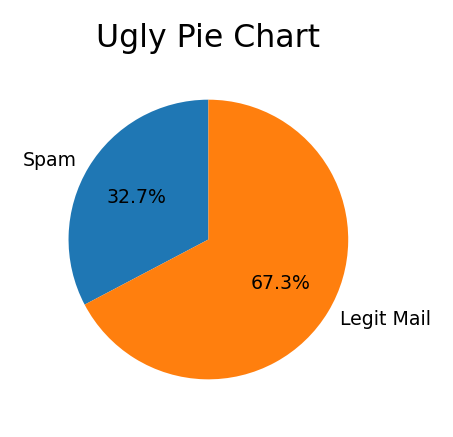

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%%')
plt.title('Ugly Pie Chart', fontdict={'fontsize': 10})
plt.show()

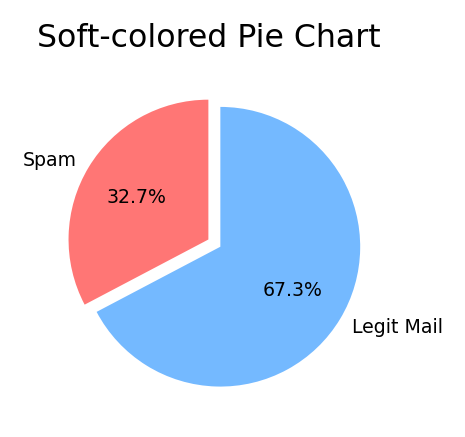

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%%',
        colors=custom_colors, explode=[0, 0.1])

plt.title('Soft-colored Pie Chart', fontdict={'fontsize': 10})
plt.show()

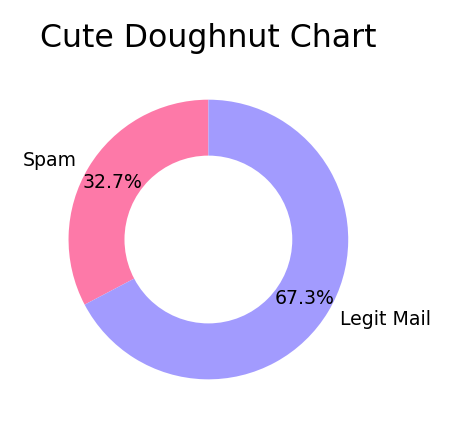

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#fd79a8', '#a29bfe']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%%',
        colors=custom_colors, pctdistance=0.8)

# Draw a circle
center_circle = plt.Circle((0, 0), radius= 0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.title('Cute Doughnut Chart', fontdict={'fontsize': 10})
plt.show()

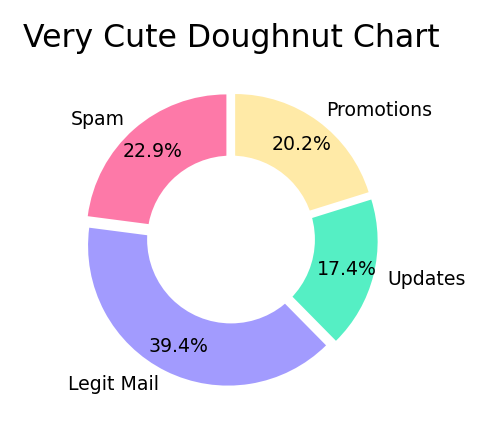

In [35]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#fd79a8', '#a29bfe', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%%',
        colors=custom_colors, pctdistance=0.8, explode=offset)

# Draw a circle
center_circle = plt.Circle((0, 0), radius= 0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.title('Very Cute Doughnut Chart', fontdict={'fontsize': 10})
plt.show()

# Natural Language Processing

## Text Pre-Processing

In [36]:
# Converting strings to lower case with .lower()
msg = "All work and no play makes Jack a dull boy"
print(msg.lower())

all work and no play makes jack a dull boy


# Download  the NLTK Resources (Tokenizer & Stopwords)

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /Users/mac/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /Users/mac/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenising

In [39]:
msg = "All work and no play makes Jack a dull boy"
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Remove Stop Words

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
if 'this' in stop_words: print('Found it!')

Found it!


In [43]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [44]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."

words = word_tokenize(msg.lower())

# Appending non-stop words to filtered_words list

filtered_words = []

for word in words:
    if word not in stop_words: 
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stem and Steming

In [45]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. Nobody spects Spanish Inquisition"

words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

# Appending non-stop words to filtered_words list

filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'spect', 'spanish', 'inquisit']


## Removing Punctuation

In [46]:
# .isalpha() function is a python method that evaluates whether a character is a letter (alpha) or punctuation

# 'E'.isalpha() >>> True
# '!'.isalpha() >>> False

In [47]:
msg = "All work and no play makes Jack a dull boy. To be or not to be ???. Nobody spects Spanish Inquisition!!!"

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        #if word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
                    
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'spect', 'spanish', 'inquisit']


## Removing HTML Tags from Emails

In [48]:
# To acces a message from our dataset we use .at[] method wich has index num and column name as arguments

soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout
<http: optout="" www.insuranceiq.com

In [49]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

## Functions for Email Processing

In [50]:
def clean_message(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    
    # Converts to lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [51]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [221]:
# Modifiying the function to remove HTML tags. Testing on email DOC_ID 2.

def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                      stop_words=set(stopwords.words('english'))):
    """
    A function that will take a single email as message and then will remove html tags, tokenize and convert 
    to lower case and then stemm each single word, returning a list of clean words.
    """
    
    # Removing html tags
    soup = BeautifulSoup(message, 'html.parser')
    msg = soup.get_text()
    
    # Converts to lower case and splits up the words
    words = word_tokenize(msg.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#            filtered_words.append(word)
            
    return filtered_words

In [222]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

# Applying Cleaning and Tokenisation to all Messages

### Applying Slicing Dataframes and Series & Creating Subsets

In [54]:
# data.iat[] method uses a location to call an specific value in our dataset, 
# first argument calls index position, the second one calls column position

data.iat[2, 1]

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [55]:
data.iloc[0:5]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [56]:
first_emails = data['MESSAGE'].iloc[0:3]

nested_list = first_emails.apply(clean_message)
type(nested_list)

pandas.core.series.Series

In [57]:
#flat_list = []

# for sublist in nested_list:
#    for item in sublist:
#        flat_list.append(item)

# List comprehension method
flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

390

In [223]:
%%time

# Using apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/Users/mac/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/mac/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 44.8 s, sys: 2.38 s, total: 47.2 s
Wall time: 50.7 s


In [224]:
nested_list.head()

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

In [225]:
nested_list.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [61]:
data[data['CATEGORY'] == 1].shape

(1896, 3)

In [62]:
data[data['CATEGORY'] == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1891,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",01311.43bfe86df65d53c5f7ca2365dc12582b
1892,1,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,00851.dc5452f80ba0bb8481dfc48f70380c4d
1893,1,Hello:\n\n\n\nAre you satisfied with your ISP?...,01328.b23902de23cb3ca1f3334517282372b2
1894,1,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,01244.9ef966101737a6fc27d8965def288d70
1895,1,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,00788.b98a23c07d59156d172683fc29b80661


In [63]:
# Creating two variables (doc_ids_spam, doc_ids_ham) 
# which holds onto the indices for the spam and the non-spam respectively

# These variables allow us to know where each category starts and ends based on their index number:
doc_ids_spam = data[data['CATEGORY'] == 1].index
doc_ids_ham = data[data['CATEGORY'] == 0].index

In [64]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [65]:
doc_ids_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_ID', length=1896)

### Subsetting a Series with an Index

In [66]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [67]:
type(nested_list)

pandas.core.series.Series

In [68]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [69]:
nested_list_ham.shape

(3900,)

In [70]:
nested_list_ham.head()

DOC_ID
1896    [message, dated, jamesr, writes, situation, wo...
1897    [hiya, always, seem, get, errors, apt, update,...
1898    [know, one, expect, better, secure, code, comm...
1899    [tim, peters, wrote, run, experiments, trainin...
1900    [jim, whitehead, wrote, great, half, need, bec...
Name: MESSAGE, dtype: object

In [71]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.head()

DOC_ID
0    [dear, homeowner, interest, rates, lowest, poi...
1    [attention, must, computer, users, package, de...
2    [message, mime, format, dare, try, find, bette...
3    [important, information, new, domain, names, f...
4    [bottom, line, give, away, cd, free, people, l...
Name: MESSAGE, dtype: object

In [72]:
type(nested_list_ham)

pandas.core.series.Series

In [103]:
# using Python list comprehension to find total number of words in clean dataset for spam and normal emails
# Finding the top 10 words in each category

spam_list = [item for sublist in nested_list_spam for item in sublist]

ham_list = [item for sublist in nested_list_ham for item in sublist]

In [104]:
spam_count = pd.Series(spam_list).value_counts()
ham_count = pd.Series(ham_list).value_counts()

print(spam_count.shape[0])
print(ham_count.shape[0])

18021
30097


In [105]:
spam_count[:10]

http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
dtype: int64

In [106]:
ham_count[:10]

http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
dtype: int64

In [107]:
print(f'Word count for spam emails is: {len(spam_list)}')
print(f'Word count for ham emails is: {len(ham_list)}')

# The count in both lists includes repeated words

Word count for spam emails is: 317482
Word count for ham emails is: 442046


In [108]:
counter_spam = Counter(spam_list)
counter_ham = Counter(ham_list)

most_occur_spam = counter_spam.most_common(10)
most_occur_ham = counter_ham.most_common(10)

print(f'Most common words for spam emails are: {most_occur_spam}')
print('\n')
print(f'Most common words for ham emails are: {most_occur_ham}')

Most common words for spam emails are: [('http', 2902), ('email', 2775), ('free', 2583), ('click', 1945), ('please', 1824), ('get', 1710), ('business', 1635), ('list', 1549), ('money', 1541), ('one', 1504)]


Most common words for ham emails are: [('http', 6609), ('list', 2662), ('one', 2247), ('would', 2003), ('get', 1780), ('like', 1729), ('use', 1704), ('wrote', 1679), ('new', 1500), ('people', 1458)]


# Creating a word cloud

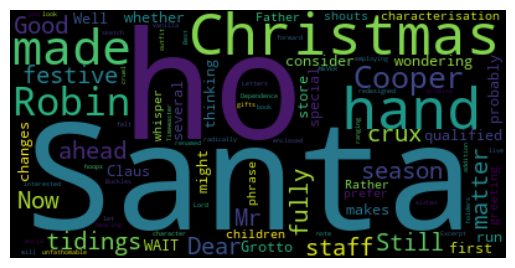

In [109]:
word_cloud = WordCloud().generate(email_body)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [110]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [111]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [112]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

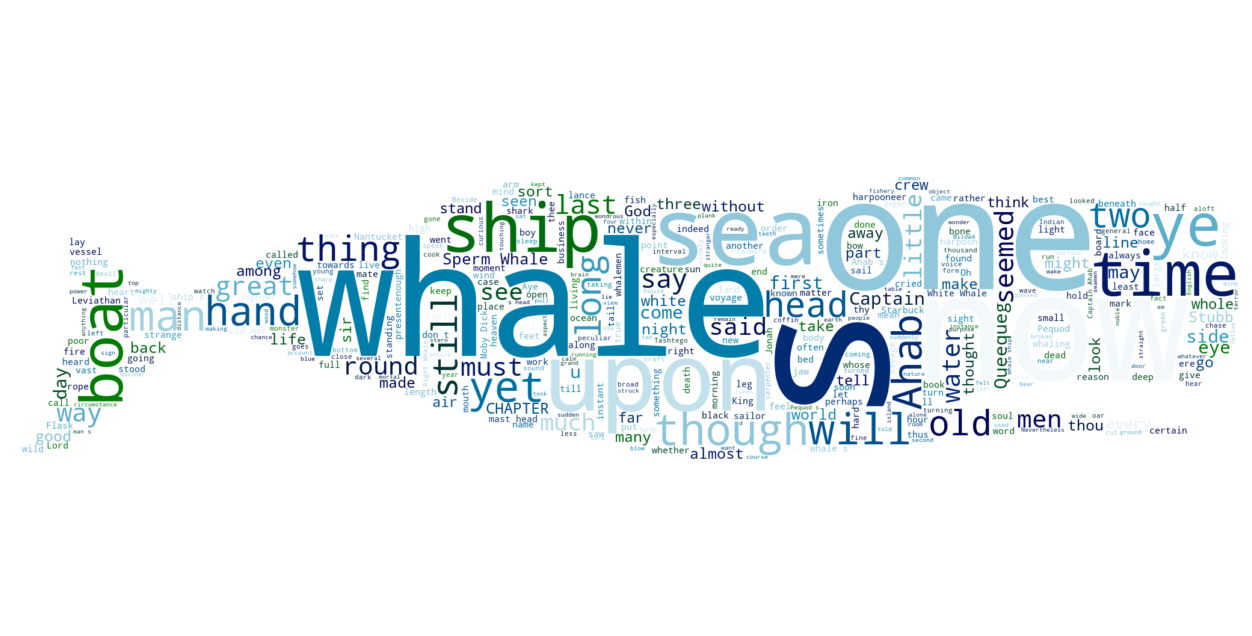

In [113]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # Converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

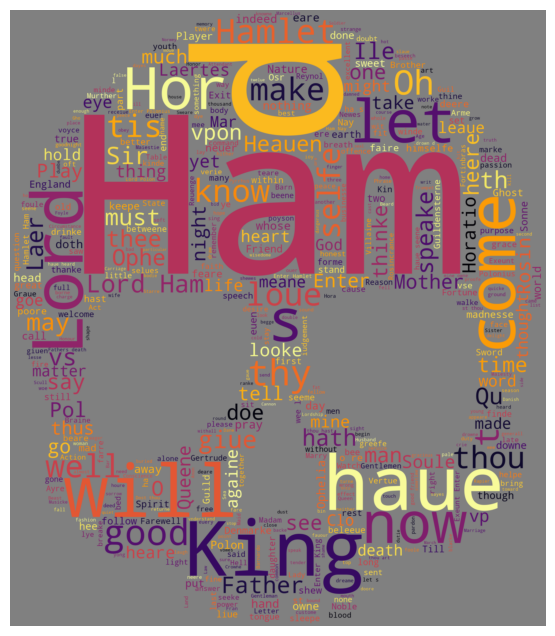

In [114]:
# Creating a skull wordcloud from Shakespeare's Hamlet 

hamlet_example = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

word_list = [''.join(word) for word in hamlet_example]
novel_as_string = ' '.join(word_list)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # Converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='gray', max_words=500, colormap='inferno')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[8, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages 

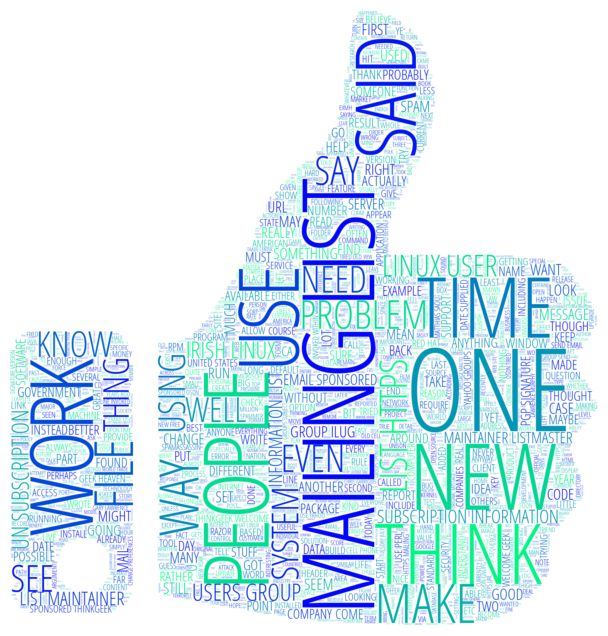

In [129]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # Converts the image object to an array

# Generate the text as string for the word cloud
ham_str = ' '.join(ham_list)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=2000, 
                       colormap='winter', font_path=LIGHT_FONT, max_font_size=300)
word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

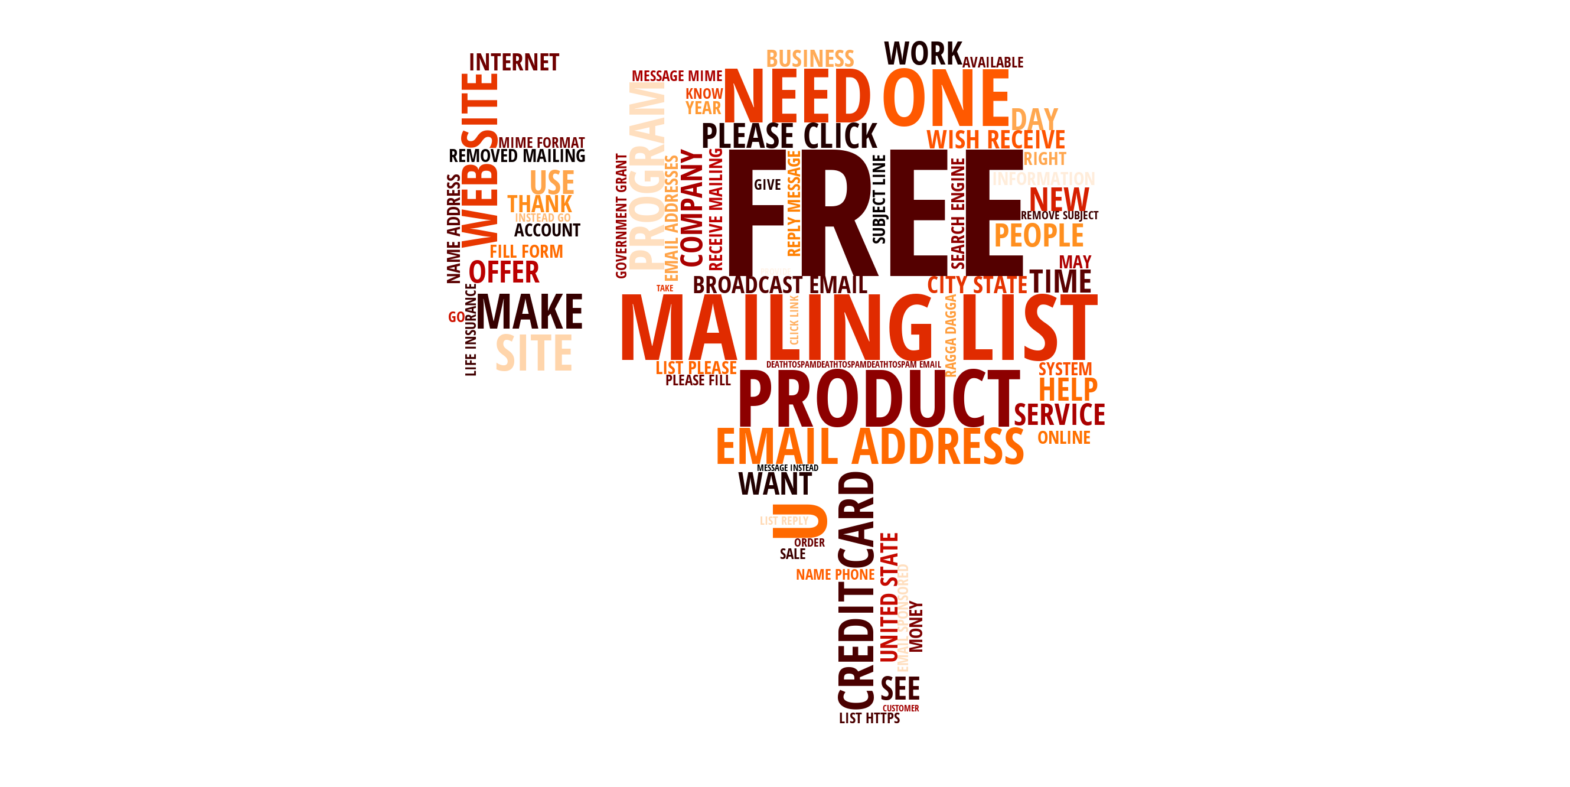

In [130]:
# Creating a word cloud for spammy words
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # Converts the image object to an array

# Generate the text as string for the word cloud
spam_str = ' '.join(spam_list)

word_cloud = WordCloud(font_path=BOLD_FONT, mask=rgb_array, background_color='white', 
                       max_words=2000, colormap='gist_heat', max_font_size=300)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[20, 12])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Generate Vocabulary & Dictionary

In [226]:
# Creating a variable that holds all words from data, tokenized, cleaned and stemmed 

stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [227]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27332


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [228]:
# Creating a subset that only contains the most common 2500 words out of the total unique words
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words[:10]

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

## Create Vocabulary DataFrame with a WORD_ID

In [229]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head(10)

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get
5,mail
6,one
7,free
8,time


## Save the Vocabulary as a CSV File

In [230]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Excercise: Checking if a Word is Part of the Vocabulary

In [ ]:
# Writting a line of code that checks if a particular word is part of the vocabulary. 
# It must return True if the word is among the 2500 that comprise the vocabulary, and False otherwise

# Words to check: 
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [231]:
# This method apparently didn't work
words_to_check = ['machine', 'learning', 'fun', 'learn', 'data', 'science', 'app', 'brewery']

def check_word(word_list):
    
    for word in word_list:
        check = word in set(vocab.VOCAB_WORD)
        print(word, check)
        

In [232]:
check_word(words_to_check)

machine False
learning False
fun True
learn True
data True
science False
app True
brewery False


In [233]:
# There are two ways on checking whether a words appears in our dictionary, an innefficient and an efficient:

# Innefficient way:
any(vocab.VOCAB_WORD == 'machine')

# Effcient way:
'machine' in set(vocab.VOCAB_WORD)

False

# Excercise: Finding the Email with the Most Number of Words

In [ ]:
# Challenge: Print out the number of words in the longest email (after cleaning and stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed list of words 
# in the longest email. Print out the longest email from the data dataframe.

In [238]:
# My solution
def longest_email(series):    
    max_len = max(series.str.len())
    email_pos = series[series.str.len() == max_len].index
    long_email = data.iloc[email_pos]
    
    print('Max length email:', max_len)
    print('Longest email position at:', email_pos[0])
    print(long_email)



In [239]:
longest_email(stemmed_nested_list)

Max length email: 7671
Longest email position at: 5401
        CATEGORY                                            MESSAGE  \
DOC_ID                                                                
5401           0  ------------------------ Yahoo! Groups Sponsor...   

                                     FILE_NAME  
DOC_ID                                          
5401    01380.e3fad5af747d3a110008f94a046bf31b  


In [210]:
# Solution from the course
clean_email_lenghths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [212]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Number of words in the longest email:', max(clean_email_lengths))

# Using a numpy function to find the max value in our list
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Number of words in the longest email: 7671
Email position in the list (and the data dataframe) 5401


In [213]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [214]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with One Word Per Column

In [240]:
type(stemmed_nested_list)

pandas.core.series.Series

In [241]:
type(stemmed_nested_list.tolist())

list

In [243]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [245]:
word_columns_df.shape

(5796, 7671)

# Splitting the Data into a Training and Testing Dataset

In [254]:
# Splitting data into train (70%) and testing sub datasets
# Using a seed value of 42 to shuffle the data

X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size= 0.3, random_state=42)


In [257]:
print(f"No. of training examples: {X_train.shape[0]}")
print(f"Fraction of training set: {X_train.shape[0]/word_columns_df.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

No. of training examples: 4057
Fraction of training set: 0.6999654934437544
No. of testing examples: 1739


In [259]:
X_train.index.name = X_test.index.name ='DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [260]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [261]:
# Variable that will hold index numbers for each word of our dataset
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [262]:
# Getting index from a specif word in VOCAB_WORD column
word_index.get_loc('thu')

392

In [270]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {
                    'LABEL': category, 
                    'DOC_ID': doc_id, 
                    'OCCURENCE': 1, 
                    'WORD_ID': word_id
                }
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)   

In [271]:
%%time 

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 10min 17s, sys: 5.34 s, total: 10min 22s
Wall time: 10min 32s


In [272]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,392
1,0,4844,1,493
2,0,4844,1,2383
3,0,4844,1,496
4,0,4844,1,37


In [273]:
sparse_train_df.shape

(444948, 4)

In [274]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
444943,1,860,1,126
444944,1,860,1,645
444945,1,860,1,516
444946,1,860,1,1395
444947,1,860,1,1071


### Combine Ocurrences with Pandas groupby() Method

In [305]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       16      1              1
       18      1              1
       24      1              1

In [286]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [314]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,16,1,1
3,0,18,1,1
4,0,24,1,1


In [315]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
265572,5795,1825,0,1
265573,5795,1892,0,2
265574,5795,2116,0,1
265575,5795,2273,0,1
265576,5795,2454,0,1


In [317]:
vocab.at[1892, 'VOCAB_WORD']

'welch'

In [300]:
data.MESSAGE[5795]

'If you run Pick, and then use the "New FTOC" button to show only\n\nthose messages selected by pick, then the ftoc display was considered\n\n"invalid" in the old code.  This prevented the display from being cached,\n\nand it meant that you could get back to the full folder display by\n\nclicking on the folder lablel.  That doesn\'t work anymore.  You have\n\nto resort to Rescan Folder.  In fact, when you change folders you\n\ncontinue to have the Pick results, not the new folder contents.\n\nIf you go to a any folder and do Rescan, then it heals itself.\n\n--\n\nBrent Welch\n\nSoftware Architect, Panasas Inc\n\nPioneering the World\'s Most Scalable and Agile Storage Network\n\nwww.panasas.com\n\nwelch@panasas.com\n\n\n\n\n\n\n\n\n\n_______________________________________________\n\nExmh-workers mailing list\n\nExmh-workers@redhat.com\n\nhttps://listman.redhat.com/mailman/listinfo/exmh-workers\n\n\n\n\n'

In [301]:
train_grouped.shape

(265577, 4)

### Save Training Data as .txt File

In [303]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [320]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Create a sparse matrix for the test data. Grouping the occurrences of the same word in the same email. Save the data as a .txt file

In [318]:
%%time 

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 4min 34s, sys: 3.87 s, total: 4min 38s
Wall time: 4min 47s


In [326]:
sparse_test_df.shape

(187640, 4)

In [321]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      7       1              1
       8       1              1
       12      1              1
       21      1              2
       26      1              1

In [322]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,21,1,2
4,8,26,1,1


In [328]:
test_grouped.shape

(110579, 4)

In [325]:
# Saving test data file in .txt format
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and checking understanding

In [ ]:
# Checking how many emails were included in the testing.txt file. Counting the number in the test_grouped dataframe
# How many emails were included in the X_test Dataframe? is the number the same? 
# Which emails were excluded and why? Compate the DOC_ID values to find out

In [388]:
train_docs_ids = set(train_grouped.DOC_ID)
test_docs_ids = set(test_grouped.DOC_ID)

In [389]:
len(test_docs_ids)

1723

In [390]:
len(X_test)

1739

In [391]:
# Checking missing emails from X_test to test_docs_ids

set(X_test.index.values) - test_docs_ids

{14,
 325,
 416,
 445,
 452,
 479,
 576,
 594,
 681,
 856,
 859,
 1001,
 1042,
 1109,
 1361,
 1407}